**PAQUETERIAS NECESARIAS**

In [1]:
## INCLUYE TODOS LOS PAQUETES A USAR
# FUNCIONES DEFINIDAS PARA USO NECESARIO
import timeit
import time
time_input = timeit.default_timer(); # tic del PROCESO INICIAL
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
import random
from tensorflow import keras
 # Bibliotecas de ayuda
import pylab as pl # SE TARDA 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import gaussian
 # Biblioteca para datos de entrenamiento
from sklearn.model_selection import train_test_split
import h5py as h # manipular extensiones

# MODIFICACION DE TAMA;OS
import mpld3
#mpld3.enable_notebook()
#from IPython.display import clear_output #
import statistics as stats # usar media o desviacion estandar
from mpl_toolkits.mplot3d import Axes3D
#import seaborn as sns
#import warnings
from IPython.display import clear_output # CLEAR EL OUT USING COMMAND
import pickle # PARA GUARDAR LOS DATOS EN UN ARCHIVO EXTERNO
import plotly.graph_objects as go # FIG APILADAS Y SLIDERS
# TIEMPO TARDADO
print(timeit.default_timer() - time_input)

5.7820687


**CONDICIONES INICIALES DE NUESTRA SIMULACION**

In [2]:
## CLASE DE LOS VALORES A TENER EN CUENTA
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.placeholder("float", [None])
#config.v_input= len(INPUT_LINEAL[0,:]); config.v_output = len(OUTPUT_LINEAL[0,:]);#, exp = 1 , cross_entropy = 1, n_iterations = 3000, dropout = 0.5):
config.n_capas  = 2;                    config.exp      = 1;
#self.matrix_neuronas = {} # SE RELLENARA EN EL FUTURO
config.learning_rate = 1e-1; config.cross_entropy = 1;    config.n_iterations  = 3000;
config.dropout       = 0.5;
config.n_step_visual_process = 10;
config.acc_corte = .8;
config.n_iterations_resul_mean = 10 ; # NUMERO DE VECES EN QUE SE REALIZARA LA MISMA OPERACION PARA OBTENER VALORES MEDIOS
## DEFINIR QUE PORCIENTO DE NUESTROS DATOSS SERAN UTILIZADOS
config.porciento_datos = .1 ;
config.porciento_para_test  = .2 ;

**FUNCIONES INICIALES Y NECESARIAS PARA EL ENTRENAMIENTO**

In [3]:
## FUNCION DE CORTE ALEATORIAMENTE ESCOGIDO LOS DATOS
def fcorte(INPUT_LINEAL, OUTPUT_LINEAL,corte):
    # SEPARAR LA INFO PARA ENTRENAR DE LA QUE SERA USADA PARA EL TEST DE CORRESPONDENCIA
    INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL, OUTPUT_LINEAL_TEST = train_test_split( 
                                               INPUT_LINEAL, OUTPUT_LINEAL, test_size=corte, shuffle = True);
    return INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL, OUTPUT_LINEAL_TEST
    
# ENTRAR LA INFORMACION DESDE UN ARCHIVO EXTERNO Y SELECCIONAR QUE PORCIENTO DE ELLA VAMOS A CARACTERIZAR    
def fdatos(config):
    FILE  = h.File("DATOS/TODOS.h5", 'r')
    # SACAR EL PORCIENTO DEL ARCHIVO
    
    INPUT1 = FILE["qcd/images"][:]    ;      INPUT1 = np.reshape(INPUT1, [len(INPUT1),-1]) ;
    #print(np.ones( INPUT1.shape[0], 2 ))
    LABEL1 = np.ones( ( INPUT1.shape[0], 2 ) ) ; LABEL1[:,1] = 0 ;
    INPUT1_NOUSED, INPUT1_USED, LABEL1_NOUSED, LABEL1_USED = train_test_split( 
                                INPUT1 , LABEL1 , test_size = config.porciento_datos , shuffle = True);
    
    INPUT2 = FILE["wprime/images"][:] ;      INPUT2 = np.reshape(INPUT2, [len(INPUT2),-1]) ;
    LABEL2 = np.zeros( ( INPUT2.shape[0], 2 ) ) ;  LABEL2[:,1] = 1 ;
    INPUT2_NOUSED, INPUT2_USED, LABEL2_NOUSED, LABEL2_USED  = train_test_split( 
                                INPUT2 , LABEL2 , test_size = config.porciento_datos , shuffle = True);
    # UNIR LAS ENTRADAS EN UNA SOLA
    #print(INPUT2_USED.shape)
    #print(INPUT1_USED.shape)
    #print(INPUT2.shape)
    #print(INPUT1.shape)
    #print(config.porciento_datos)
    INPUT = np.vstack( [INPUT1_USED, INPUT2_USED] ); 
    INPUT = INPUT/np.max( np.vstack( [INPUT1, INPUT2] ) ) # SE NORMALIZA
    
    #LABEL = np.hstack([FILE["qcd/labels"][:], FILE["wprime/labels"][:]])
    #print(np.ones( (INPUT1.shape[0],1)))
    OUTPUT = np.concatenate((LABEL1_USED,LABEL2_USED), axis=0) ; #np.vstack( [ LABEL1_USED, LABEL2_USED ] );
    
    config.v_input= len(INPUT[0,:]); config.v_output = len(OUTPUT[0,:]);
    return config, INPUT , OUTPUT ;

                                

In [4]:
## DATOS QUE UTILIZAREMOS EN NUESTRA PRIMERA CORRIDA DE PRUEBA
config.porciento_datos = .999 ; # PORCIENTO DEL CORTE DE DATOS ORIGINAL
config, INPUT_LINEAL , OUTPUT_LINEAL  = fdatos(config);
print(INPUT_LINEAL.shape)
INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL, OUTPUT_LINEAL_TEST = fcorte(INPUT_LINEAL, OUTPUT_LINEAL,config.porciento_para_test );
print(INPUT_LINEAL.shape)
## NO DEBEN VOLVERSE A DEFINIR BAJO NINGUN CONCEPTO
config.X = tf.compat.v1.placeholder("float", shape = [None,len(INPUT_LINEAL[0,:])]  ) #, name= "input_size2"); # Estructura de la entrada
config.Y = tf.compat.v1.placeholder("float", shape = [None,len(OUTPUT_LINEAL[0,:])] ) #, name= "output_size2") #Estructura de la salida


(13110, 625)
(10488, 625)


In [5]:
## LLEVAR LA INFO DE SEGUNDOS A TIEMPO EXTENDIDO
def frantime(segundos):
    dias= np.fix(segundos/86400);                           hor = np.fix( ( segundos - dias*86400 )/3600 ); 
    min = np.fix( ( segundos - dias*86400 - hor*3600)/60 ); seg = np.fix( ( segundos - dias*86400 - hor*3600 - min*60 ) );
    salida = [dias,hor,min,seg]
    return salida

In [6]:
## DEFINICION DE LOS MODOS DE ELECCION DE CAPAS OCULTAS Y NUMEROS DE NEURONAS
def neuronas( config ): #v_input, v_output, n_capas = 2, exp = 1,  modo = 'poly' ):
    #config = Dd()
    x = np.ones(config.n_capas + 2)
    #print(x)
    if  config.exp >= 1: #modo == 'poly':
        for i in range(config.n_capas + 2):
            x[len(x)-i-1] = round(( config.v_input - config.v_output )*pow(i/(config.n_capas + 1 ), config.exp) + config.v_output)
            #print(x[i])
            #print(i)
    elif config.exp < 1:
        for i in range(config.n_capas + 2):
            x[len(x)-i-1] = round(( config.v_input - config.v_output )*pow(i/( config.n_capas + 1 ), -1/config.exp) + config.v_output)
            #print(x[i])
            #print(i)
    config.matrix_neuronas = np.int64(x)
    return config

In [7]:
## ORGANIZACION DE LA ESTRUCTURA INTERNA DE ENTRENAMIENTO ##
def estructura( INPUT_LINEAL, OUTPUT_LINEAL , config):
    config = neuronas( config )
    #proceso iteractivo dinamico 
    for i in range(len(config.matrix_neuronas)-1):

        weights = tf.Variable( tf.random.truncated_normal([config.matrix_neuronas[i], config.matrix_neuronas[i+1]], stddev=0.1) , 
                              name = f"weights-w{i}")
        biases = tf.Variable(tf.constant(0.1, shape=[config.matrix_neuronas[i+1]]) , name=f"biases_b{i}" )
        
        if  i == 0: # CONDICION INICIAL
            layer = tf.add(tf.matmul( config.X, weights), biases , name=f"layer_l{i}" )
        else: # VALORES INTERNMEDIOS
            layer = tf.add(tf.matmul(    layer, weights), biases , name=f"layer_l{i}" )
    # PARAMETROS FINALES PARA CARACTERIZACION 
    config.cross_entropy = tf.reduce_mean(tf.compat.v2.nn.softmax_cross_entropy_with_logits(labels = config.Y, logits=layer) , 
                                          name= "Definition_of_cross_entropy")
    config.train_step    = tf.compat.v1.train.AdamOptimizer( config.learning_rate ).minimize( config.cross_entropy , 
                                          name= "Definition_of_train_step")
    config.correct_pred  = tf.equal(tf.argmax(layer, 1), tf.argmax( config.Y , 1) , 
                                          name= "Definition_of_correct_pred")
    config.accuracy      = tf.reduce_mean(tf.cast( config.correct_pred  , tf.float32) ,
                                          name= "Definition_of_accuracy")
    return config

## INICIO DE LA ITERACION
def inicio( INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL , OUTPUT_LINEAL_TEST , config):
    
    init = tf.compat.v1.global_variables_initializer()
    config.cost_summary = tf.compat.v1.summary.scalar("Cost", config.cross_entropy)
    config.acc_summary = tf.compat.v1.summary.scalar("Accuracy", config.accuracy)
    config.all_summary = tf.compat.v1.summary.merge_all()#'''
    #saver=tf.train.Saver() #SALVAR LA SECCION PARA PODERLA UTILIZAR LUEGO
    with tf.compat.v1.Session() as sess: #tf.Session() as sess:
        #writer = tf.summary.FileWriter("Tensorboard", sess.graph)
        writer = tf.compat.v1.summary.FileWriter("Tensorboard", sess.graph)
        #print(sess)
        sess.run(init)
        #saver.save(sess, 'modelo')
        toc_general = 0  
        for i in range(config.n_iterations):
            tic = time.process_time() ; #timeit.default_timer()
            sess.run(config.train_step, feed_dict={ config.X: INPUT_LINEAL, config.Y:OUTPUT_LINEAL}) # CORRIDA

            config.summary_results, config.loss, config.acc = sess.run([config.all_summary, config.cross_entropy, config.accuracy], 
                                                  feed_dict={config.X: INPUT_LINEAL, config.Y: OUTPUT_LINEAL})
            writer.add_summary(config.summary_results, i)
            
            toc = time.process_time() ; #timeit.default_timer() ;   
            toc_general +=  toc - tic ;
            if (i+1)%config.n_step_visual_process == 0 :
                print("\n | Info del modelo :: Iteration inst : ", '%.f' % i, 
                      "\t | Accuracy =", '%.3f' % config.acc ,
                      "\t | Loss =", '%.3f' % config.loss , 
                      "\t | Time =", '%.3f' % (toc - tic) )
            if  config.acc > config.acc_corte :
                break;
        config.test_accuracy,  config.test_loss = sess.run([config.accuracy, config.cross_entropy], 
                                                           feed_dict={config.X: INPUT_LINEAL_TEST, config.Y: OUTPUT_LINEAL_TEST})
        config.time_ite_mean = toc_general/(i+1) ;
        config.n_iterations_acc = i ;
        print("\n | Info del modelo :: Iteration Max : " , '%.f' % config.n_iterations_acc , 
              "\t | Accuracy : "                , '%.3f' % config.acc , 
              "\t | Loss : "                    , '%.3f' % config.loss     ,
              "\t | Mean time : " , '%.3f' % config.time_ite_mean  , "\t |")
        print("\n | Info de test :: Accuracy : ", '%.3f' % config.test_accuracy , 
              "\t | Loss : ", '%.3f' % config.test_loss , "\t |")
        
    return config

**CARACTERIZACION DE NUESTRA MUESTRA Y NUESTRO PROCESO DE ENTRENAMIENTO**

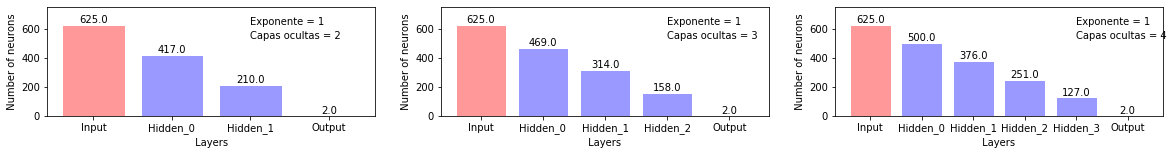

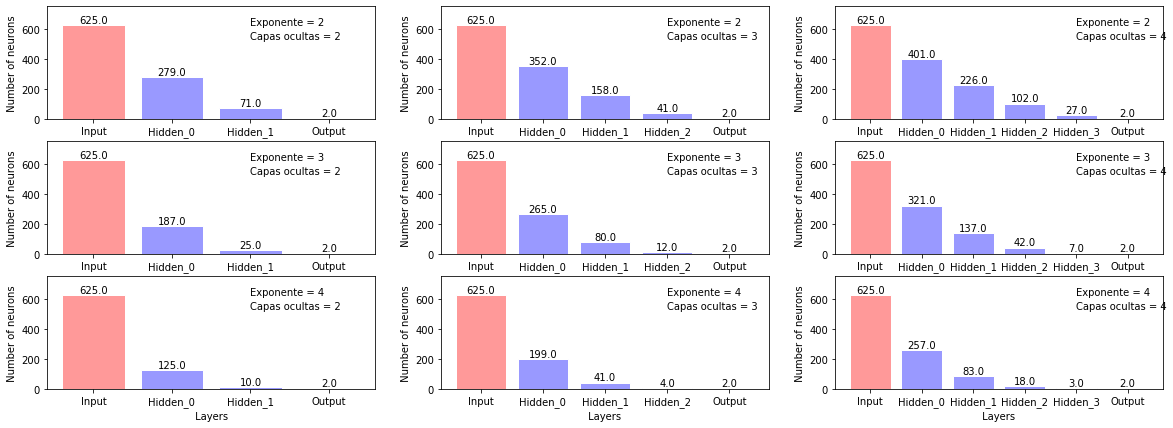

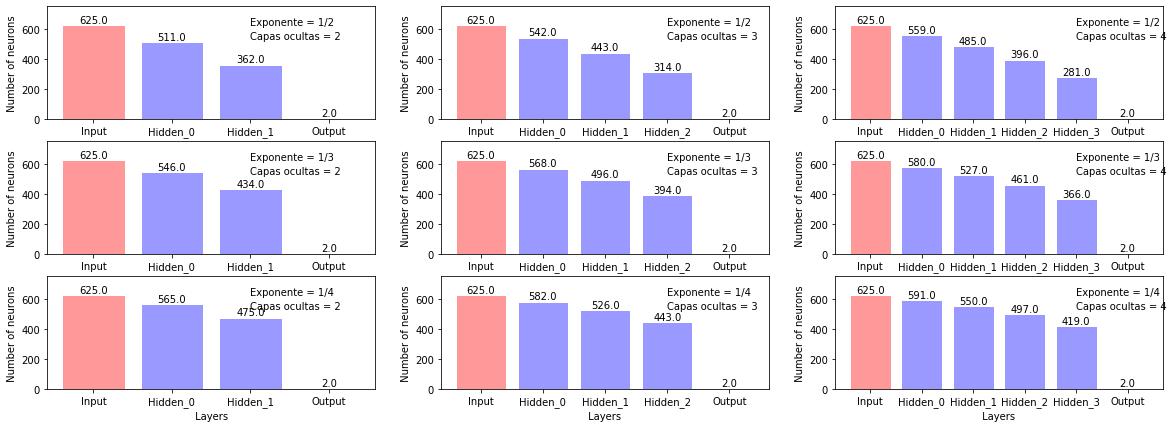

In [8]:
## GRAFICO DE VARIACION DEL PARAMETRO DE SELECCION NEURONAL POR CAPAS INCLUIDAS
def graf_capas_neuronas( exp , n_capas , config):
    config.exp = exp; config.n_capas  = n_capas;  
    config = neuronas( config )
    for i in range(len(config.matrix_neuronas)):
        if  i == 0:
            X = ["Input"]
        elif i== len(config.matrix_neuronas)-1:
            X.append("Output")
        else: 
            X.append(f"Hidden_{i-1}")
    Y = config.matrix_neuronas#(1 - X / float(n)) * np.random.uniform(0.5, 1.0, n)
    pl.bar(X[0], Y[0], facecolor='#ff9999', edgecolor='white')
    pl.bar(X[1:-1], Y[1:-1], facecolor='#9999ff', edgecolor='white')
    pl.bar(X[-1], Y[-1], facecolor='#ff9999', edgecolor='white')

    for x, y in zip(X, Y):
        pl.text(x , y + 0.05, '%.1f' % y, ha='center', va='bottom')
    pl.ylabel(' Number of neurons ') ;         pl.xlabel(' Layers ')
    pl.ylim(0, max(config.matrix_neuronas)*1.2)
    if exp >0:
        pl.text( n_capas , max(config.matrix_neuronas) , f"Exponente = {exp}")
    else:
        pl.text( n_capas , max(config.matrix_neuronas) , f"Exponente = 1/{-exp}")
    pl.text( n_capas , max(config.matrix_neuronas)*85/100 , f"Capas ocultas = {n_capas}")   

#fig, axs = plt.subplots(3,3)
#fig.suptitle('Structure of layers and neurons')
#axs[0]
plt.rcParams['figure.figsize'] = [20, 2]
plt.figure(1)
plt.subplot(131); graf_capas_neuronas( 1 , 2 , config) 
plt.subplot(132); graf_capas_neuronas( 1 , 3 , config) 
plt.subplot(133); graf_capas_neuronas( 1 , 4 , config)

plt.rcParams['figure.figsize'] = [20, 12]
plt.figure(2)
plt.subplot(531); graf_capas_neuronas( 2 , 2 , config) 
plt.subplot(532); graf_capas_neuronas( 2 , 3 , config) 
plt.subplot(533); graf_capas_neuronas( 2 , 4 , config)
plt.subplot(534); graf_capas_neuronas( 3 , 2 , config) 
plt.subplot(535); graf_capas_neuronas( 3 , 3 , config) 
plt.subplot(536); graf_capas_neuronas( 3 , 4 , config)
plt.subplot(537); graf_capas_neuronas( 4 , 2 , config) 
plt.subplot(538); graf_capas_neuronas( 4 , 3 , config) 
plt.subplot(539); graf_capas_neuronas( 4 , 4 , config) 
plt.figure(3)
plt.subplot(531); graf_capas_neuronas( -2 , 2 , config) 
plt.subplot(532); graf_capas_neuronas( -2 , 3 , config) 
plt.subplot(533); graf_capas_neuronas( -2 , 4 , config) 
plt.subplot(534); graf_capas_neuronas( -3 , 2 , config) 
plt.subplot(535); graf_capas_neuronas( -3 , 3 , config) 
plt.subplot(536); graf_capas_neuronas( -3 , 4 , config) 
plt.subplot(537); graf_capas_neuronas( -4 , 2 , config) 
plt.subplot(538); graf_capas_neuronas( -4 , 3 , config) 
plt.subplot(539); graf_capas_neuronas( -4 , 4 , config) 

In [9]:
## CARACTERIZAR SI CAMBIA EL TIEMPO MEDIO DE UNA ITERACION CON LA VARIACION DE LAS CAPAS Y NEURONAS
##PARA UN learning_rate = CONST = .1
#print("cosa")
time_input = timeit.default_timer(); # tic del PROCESO INICIAL
f = open ('log_eventos_z1z2z3.txt','w')
config.learning_rate = .01 ; 
config.acc_corte = .9; 
config.n_step_visual_process = 600;
config.n_iterations_resul_mean = 10;
#print(config)
exp = [-4, -3, -2, 1, 2, 3, 4]   ;   n_capas = [1, 2, 3, 4, 5, 6]   ;  exp_str =str(exp).strip('][)').split(',')
for i in range(len(exp_str)):    exp_str[i] = "(" + exp_str[i] + ")"
X, Y = np.meshgrid(exp , n_capas, sparse=False, indexing='ij') ; # MATRIX COMBINADA
Z_1  = np.zeros(X.shape) ;  Z_2  = np.zeros(X.shape) ;  Z_3  = np.zeros(X.shape) ; # ENTRADA DE LOS VALORES
dZ_1 = np.zeros(X.shape) ;  dZ_2 = np.zeros(X.shape) ;  dZ_3 = np.zeros(X.shape) ; # ENTRADA DE LAS DESVIACIONES RESPECTIVAS
for x in range( X.shape[0] ): 
    #print(x)
    for y in range( Y.shape[1] ):
        #print(y)
        time_ite_ALL         = np.ones(config.n_iterations_resul_mean) ;
        loss_ALL             = np.ones(config.n_iterations_resul_mean);
        n_iterations_acc_ALL = np.ones(config.n_iterations_resul_mean) ;
        config.exp = X[ x , y ] ;               config.n_capas = Y[ x , y ]
        
        config = estructura( INPUT_LINEAL, OUTPUT_LINEAL , config ); # ACTUALIZAR LA ESTRUCTURA PARA ENTRENAR
        for i in range(config.n_iterations_resul_mean):
            config = inicio( INPUT_LINEAL, INPUT_LINEAL_TEST, OUTPUT_LINEAL , OUTPUT_LINEAL_TEST , config) # CORRER EL PROGRAMA
            # INCLUIR DENTRO DEL VECTOR DE RESULTADOS
            time_ite_ALL[i]         = config.time_ite_mean ;
            loss_ALL[i]             = config.loss ;
            n_iterations_acc_ALL[i] = config.n_iterations_acc ;
            '''if i == config.n_iterations_resul_mean-1:
                print(time_ite_ALL)
                print(loss_ALL)
                print(n_iterations_acc_ALL)'''
       
        # OBTENER LOS VALORES IMPORTANTES DE CADA ITERACION
        Z_1[ x , y ] = stats.mean( time_ite_ALL );         dZ_1[ x , y ] = stats.stdev( time_ite_ALL );   
        Z_2[ x , y ] = stats.mean( loss_ALL );             dZ_2[ x , y ] = stats.stdev( loss_ALL );  
        Z_3[ x , y ] = stats.mean( n_iterations_acc_ALL ); dZ_3[ x , y ] = stats.stdev( n_iterations_acc_ALL );  
        # MENSAJE DE SALIDA    
        clear_output() # CLEAR PREVIOS INFO
        print(x, " " , y , " ", X.shape[0], " ",Y.shape[1],  " ", " ")
        porciento = 100 * ( ( x )*Y.shape[1] + y + 1 )/( X.shape[0]*Y.shape[1] ); # PORCIENTO DEL PROCESO DE SALIDA
        time_pass = frantime(np.abs(timeit.default_timer() - time_input )); # TIEMPO EN QUE OCURREN LOS PROCESOS
        time_will = frantime(np.abs(timeit.default_timer() - time_input ) / porciento * 100 ); # TIEMPO EN QUE OCURREN LOS PROCESOS
        print( "> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - <" );
        print( "\n AVANCE :: " , "\t Progreso de todo el evento : " , '%.1f'%porciento , 
               "\n %      :: Tiempo de ejecucion : ", '%.f'%float(time_pass[0]), "/" , '%.f'%float(time_pass[1]), "/"
                             , '%.f'%float(time_pass[2]), "/", '%.f'%float(time_pass[3]),
               "\t % :: Tiempo esperado para terminar : ", '%.f'%float(time_will[0]), "/" , '%.f'%float(time_will[1]), "/"
                             , '%.f'%float(time_will[2]), "/", '%.f'%float(time_will[3])
             );
        print( "   - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   " );
        print( "\n Valores de Exponencial : " , '%.f' % X[ x , y ] , 
               "\t :: Numeros de Capas : "    , '%.f' % Y[ x , y ]) 
        #print( time_ite_ALL )
        #print( loss_ALL )
        #print( n_iterations_acc_ALL )    
        print( "\n Valores Medios de :: Tiempo de una iteracion   : ", '%.3f' %Z_1[x,y] , " + ", '%.3f' % dZ_1[x,y] )
        print( "\n Valores Medios de :: Perdida                   : ", '%.3f' %Z_2[x,y] , " + ", '%.3f' % dZ_2[x,y] )
        print( "\n Valores Medios de :: Iteracion de convergencia : ", '%.1f' %Z_3[x,y] , " + ", '%.1f' % dZ_3[x,y] )
        print( "> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - <" );

6   5   7   6    
> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - <

 AVANCE ::  	 Progreso de todo el evento :  100.0 
 %      :: Tiempo de ejecucion :  0 / 9 / 42 / 43 	 % :: Tiempo esperado para terminar :  0 / 9 / 42 / 43
   - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -   

 Valores de Exponencial :  4 	 :: Numeros de Capas :  6

 Valores Medios de :: Tiempo de una iteracion   :  18.336  +  0.137

 Valores Medios de :: Perdida                   :  0.274  +  0.027

 Valores Medios de :: Iteracion de convergencia :  23.9  +  4.4
> - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - <


In [ ]:
exp = [-4, -3, -2, 1, 2, 3, 4]   ;   n_capas = [1, 2, 3, 4, 5, 6]   ;  exp_str =str(exp).strip('][)').split(',')
for i in range(len(exp_str)):    exp_str[i] = "(" + exp_str[i] + ")"

In [10]:
## SAlVAR NUESTRAS VARIABLES PARA USO FUTURO
output = open('Var_z1z2z3.pkl', 'wb') # CREAR EL ARCHIVO DE GUARDADO
# Pickle dictionary using protocol 0.
pickle.dump( X ,output)   ;  pickle.dump( Y ,output) ; 
pickle.dump( Z_1,output)   ;   pickle.dump( Z_2,output)   ;   pickle.dump( Z_3,output)   ;
pickle.dump( dZ_1,output)  ;  pickle.dump( dZ_2,output)   ;  pickle.dump( dZ_3,output)   ;
#pickle.dump([ Z_1 , Z_2 , Z_3 , dZ_1 , dZ_2 , dZ_3 ],output)
output.close()

In [11]:
## CARGAR NUESTRAS VARIABLES PARA USO 
pkl_file = open('Var_z1z2z3.pkl', 'rb')
X    = pickle.load(pkl_file)  ; Y    = pickle.load(pkl_file) ; 
Z_1  = pickle.load(pkl_file)  ; Z_2  = pickle.load(pkl_file) ; Z_3 = pickle.load(pkl_file)  ;
dZ_1 = pickle.load(pkl_file)  ; dZ_2 = pickle.load(pkl_file) ; dZ_3 = pickle.load(pkl_file) ;
output.close()

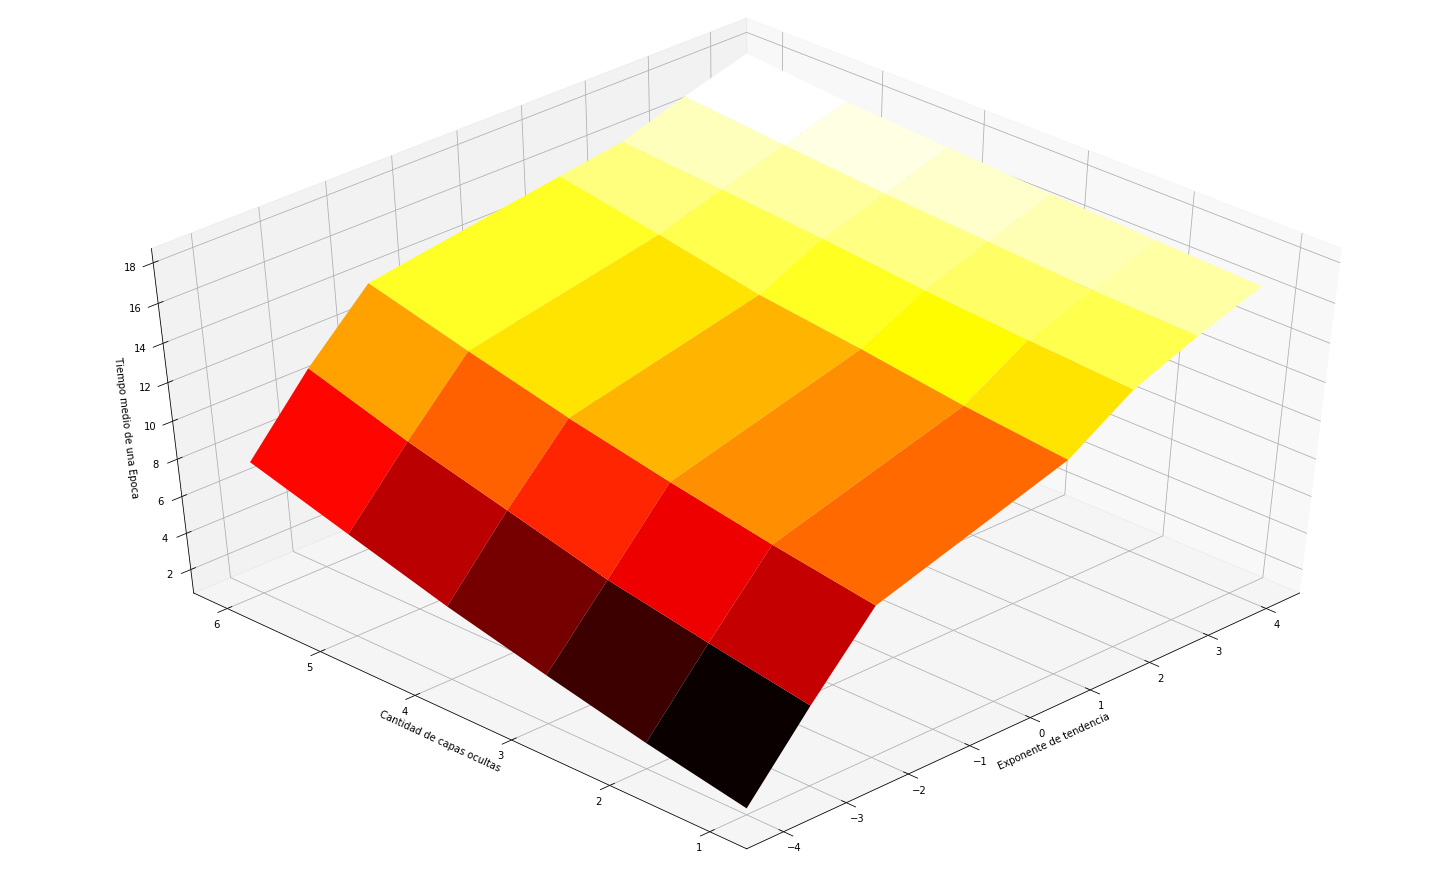

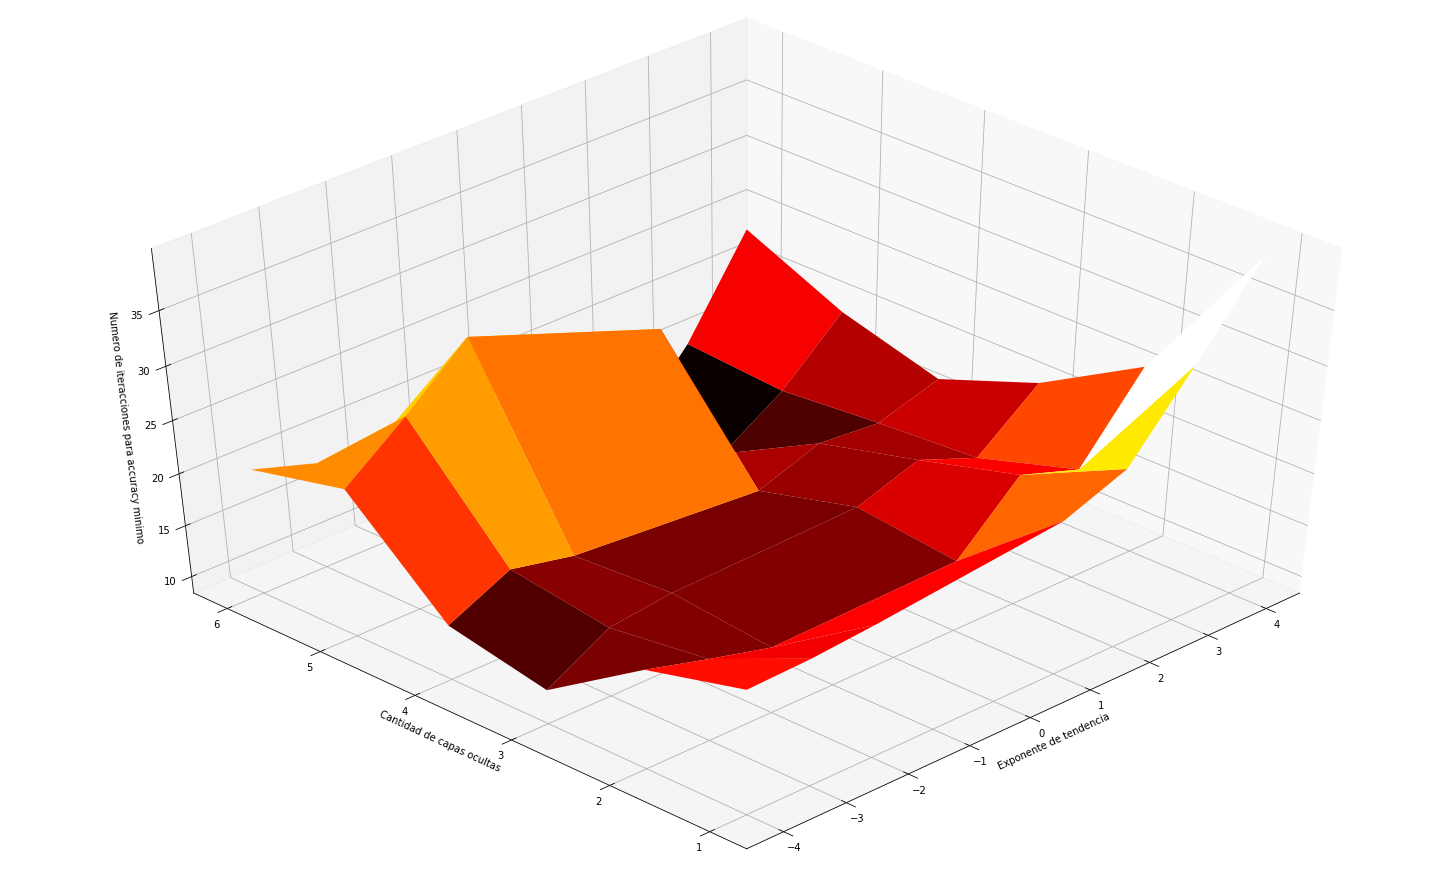

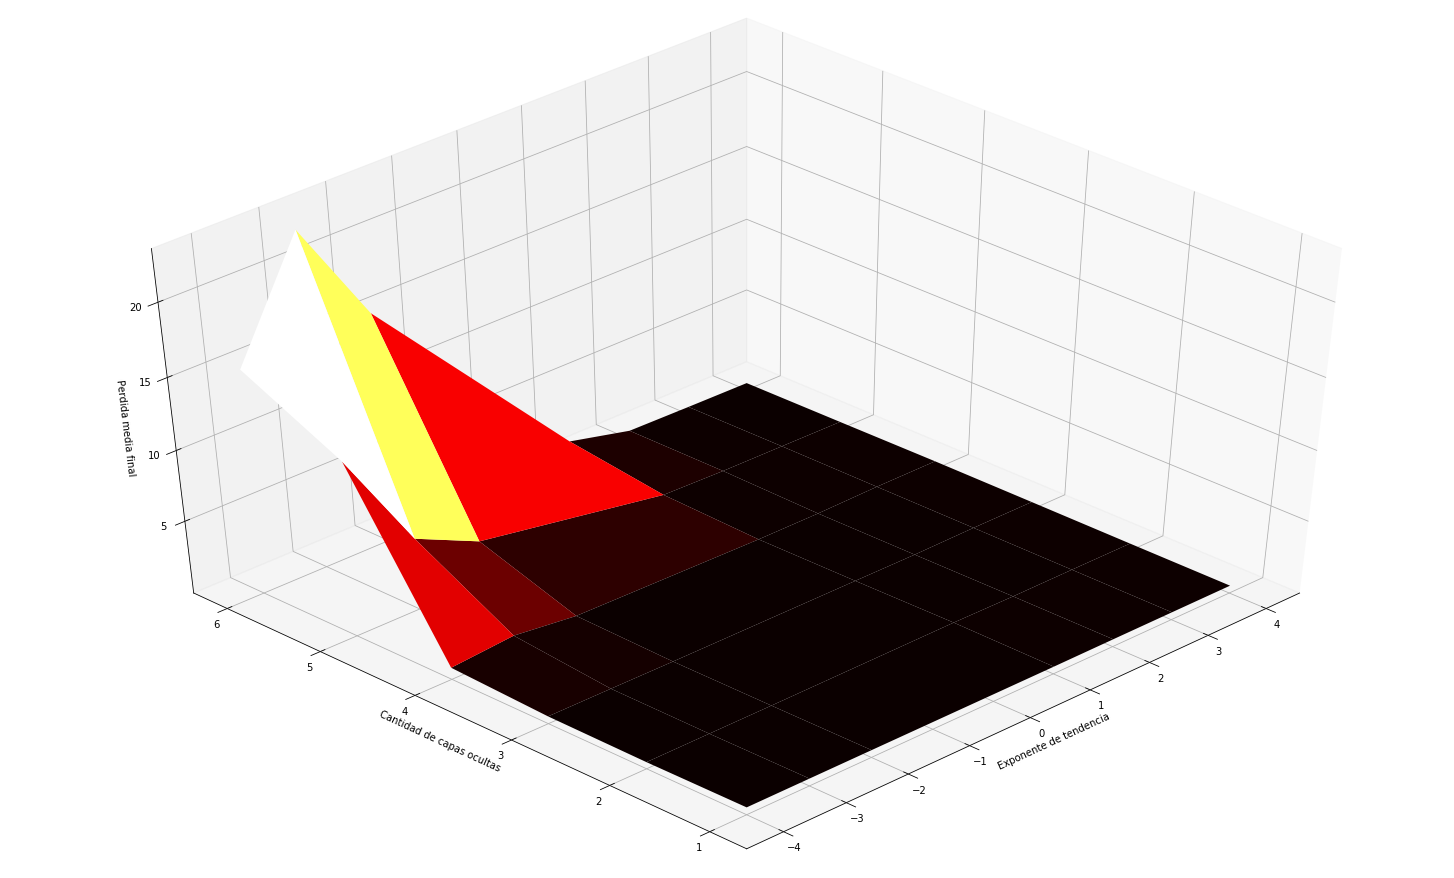

In [12]:
## GRAFICOS 3D PARA CARACTERIZACION
fig = pl.figure(1) ;  ax = Axes3D(fig) ;
ax.plot_surface(X, Y, Z_1, rstride=1, cstride=1, cmap='hot')
ax.set_xlabel(' Exponente de tendencia ') ;
ax.set_ylabel(' Cantidad de capas ocultas ') ;
 ax.set_zlabel(' Tiempo medio de una Epoca ') ;
ax.view_init(45,225)

fig = pl.figure(2) ;  ax = Axes3D(fig) ;
ax.plot_surface(X, Y, Z_3, rstride=1, cstride=1, cmap='hot')
ax.set_xlabel(' Exponente de tendencia ') ;
ax.set_ylabel(' Cantidad de capas ocultas ') ;
ax.set_zlabel(' Numero de iteracciones para accuracy minimo ') ;
ax.view_init(45,225)

fig = pl.figure(3) ;  ax = Axes3D(fig) ;
ax.plot_surface(X, Y, Z_2, rstride=1, cstride=1, cmap='hot')
ax.set_xlabel(' Exponente de tendencia ') ;
ax.set_ylabel(' Cantidad de capas ocultas ') ;
ax.set_zlabel(' Perdida media final ') ;
ax.view_init(45,225)

In [ ]:
## GRAFICOS 2D CON SLIDERS PARA POSIBLE CARACTERIZACION
# Create figure
#import plotly.graph_objects as go
fig = go.Figure()
#fig.show(block=True)
# Add traces, one for each slider step
for i in np.arange(0, X.shape[0] , 1):
    fig.add_trace(go.Scatter(  visible=False,
        x=Y[i,:], y=Z_1[i,:], mode='markers', name='measured z1 graf 1', 
        error_y=dict( type='data', array=dZ_1[i,:], arrayminus = dZ_1[i,:] , color='purple', thickness=1.5, width=3) ) )
fig.data[0].visible = True# Make 10th trace visible
# Create and add slider
steps = [];
for i in range(len(fig.data)):
    #print(step)
    step = dict( method="restyle", args  =["visible", [False] * len(fig.data)], label = str(X[i,0]) )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict( active=10, currentvalue={"prefix": "Exponente de tendencia graficado: "}, pad={"t": 20}, steps=steps )]
fig.update_layout( sliders=sliders )
fig.update_layout(
    yaxis  = dict(range=[np.min(Z_1 - dZ_1), np.max(Z_1 + dZ_1)]), 
    xaxis_title="Cantidad de capas ocultas", yaxis_title="Tiempo medio de una Epoca", 
    title=" Variación del tiempo de épocas vs Exponente de tendencia",)
fig.show()

## GRAFICO DE LA OTRA DIMENSION 
fig = go.Figure()
#fig.show(block=True)
# Add traces, one for each slider step
for i in np.arange(0, Y.shape[1] , 1):
    fig.add_trace(go.Scatter(  visible=False,
        x=exp_str, y=Z_1[:,i], mode='markers', name='measured Z1 graf 2', 
        error_y=dict( type='data', array=dZ_1[:,i], arrayminus = dZ_1[:,i] , color='purple', thickness=1.5, width=3) ) )
fig.data[0].visible = True# Make 10th trace visible
# Create and add slider
steps = [];
for i in range(len(fig.data)):
    #print(step)
    step = dict( method="restyle", args  =["visible", [False] * len(fig.data)], label = str(Y[0,i]) )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict( active=10, currentvalue={"prefix": "Cantidad de capas ocultas graficado: "}, pad={"t": 20}, steps=steps )]
fig.update_layout( sliders=sliders )
fig.update_layout(
    yaxis  = dict(range=[np.min(Z_1 - dZ_1), np.max(Z_1 + dZ_1)]), 
    xaxis_title="Exponente de tendencia", yaxis_title="Tiempo medio de una Epoca", 
    title=" Variación del tiempo de épocas vs Capas ocultas",)
fig.show()

In [ ]:
## GRAFICOS 2D CON SLIDERS PARA POSIBLE CARACTERIZACION
# Create figure
#import plotly.graph_objects as go
fig = go.Figure()
#fig.show(block=True)
# Add traces, one for each slider step
for i in np.arange(0, X.shape[0] , 1):
    fig.add_trace(go.Scatter(  visible=False,
        x=Y[i,:], y=Z_2[i,:], mode='markers', name='measured z2 graf 1', 
        error_y=dict( type='data', array=dZ_2[i,:], arrayminus = dZ_2[i,:] , color='purple', thickness=1.5, width=3) ) )
fig.data[0].visible = True# Make 10th trace visible
# Create and add slider
steps = [];
for i in range(len(fig.data)):
    #print(step)
    step = dict( method="restyle", args  =["visible", [False] * len(fig.data)], label = str(X[i,0]) )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict( active=10, currentvalue={"prefix": "Exponente de tendencia graficado: "}, pad={"t": 20}, steps=steps )]
fig.update_layout( sliders=sliders )
fig.update_layout(
    yaxis  = dict(range=[np.min(Z_2 - dZ_2), np.max(Z_2 + dZ_2)]), 
    xaxis_title="Cantidad de capas ocultas", yaxis_title="Valor de la perdida al finalizar", 
    title=" Variación de la perdida al terminar el ajuste vs Exponente de tendencia",)
fig.show()

## GRAFICO DE LA OTRA DIMENSION 

fig = go.Figure()
#fig.show(block=True)
# Add traces, one for each slider step
for i in np.arange(0, Y.shape[1] , 1):
    fig.add_trace(go.Scatter(  visible=False,
        x=exp_str, y=Z_2[:,i], mode='markers', name='measured z2 graf 2', 
        error_y=dict( type='data', array=dZ_2[:,i], arrayminus = dZ_2[:,i] , color='purple', thickness=1.5, width=3) ) )
fig.data[0].visible = True# Make 10th trace visible
# Create and add slider
steps = [];
for i in range(len(fig.data)):
    #print(step)
    step = dict( method="restyle", args  =["visible", [False] * len(fig.data)], label = str(Y[0,i]) )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict( active=10, currentvalue={"prefix": "Cantidad de capas ocultas graficado: "}, pad={"t": 20}, steps=steps )]
fig.update_layout( sliders=sliders )
fig.update_layout(
    yaxis  = dict(range=[np.min(Z_2 - dZ_2), np.max(Z_2 + dZ_2)]), 
    xaxis_title="Exponente de tendencia", yaxis_title="Valor de la perdida al finalizar", 
    title=" Variación de la perdida al terminar el ajuste vs Capas ocultas",)
fig.show()


In [ ]:
## GRAFICOS 2D CON SLIDERS PARA POSIBLE CARACTERIZACION
# Create figure
#import plotly.graph_objects as go
fig = go.Figure()
#fig.show(block=True)
# Add traces, one for each slider step
for i in np.arange(0, X.shape[0] , 1):
    fig.add_trace(go.Scatter(  visible=False,
        x=Y[i,:], y=Z_3[i,:], mode='markers', name='measured z3 graf 1', 
        error_y=dict( type='data', array=dZ_3[i,:], arrayminus = dZ_3[i,:] , color='purple', thickness=1.5, width=3) ) )
fig.data[0].visible = True# Make 10th trace visible
# Create and add slider
steps = [];
for i in range(len(fig.data)):
    #print(step)
    step = dict( method="restyle", args  =["visible", [False] * len(fig.data)], label = str(X[i,0]) )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict( active=10, currentvalue={"prefix": "Exponente de tendencia graficado: "}, pad={"t": 20}, steps=steps )]
fig.update_layout( sliders=sliders )
fig.update_layout(
    yaxis  = dict(range=[np.min(Z_3 - dZ_3), np.max(Z_3 + dZ_3)]), 
    xaxis_title="Cantidad de capas ocultas", yaxis_title="Iteracion final", 
    title=" Iteracion en la que se logra la convergencia vs Exponente de tendencia",)
fig.show()

## GRAFICO DE LAS OTRA DIMENSION 

fig = go.Figure()
#fig.show(block=True)
# Add traces, one for each slider step
for i in np.arange(0, Y.shape[1] , 1):
    fig.add_trace(go.Scatter(  visible=False,
        x= exp_str, y=Z_3[:,i], mode='markers', name='measured z3 graf 2', 
        error_y=dict( type='data', array=dZ_3[:,i], arrayminus = dZ_3[:,i] , color='purple', thickness=1.5, width=3) ) )
fig.data[0].visible = True# Make 10th trace visible
# Create and add slider
steps = [];
for i in range(len(fig.data)):
    #print(step)
    step = dict( method="restyle", args  =["visible", [False] * len(fig.data)], label = str(Y[0,i]) )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict( active=10, currentvalue={"prefix": "Cantidad de capas ocultas graficado: "}, pad={"t": 20}, steps=steps )]
fig.update_layout( sliders=sliders )
fig.update_layout(
    yaxis  = dict(range=[np.min(Z_3 - dZ_3), np.max(Z_3 + dZ_3)]), 
    xaxis_title="Exponente de tendencia", yaxis_title="Iteracion final", 
    title=" Iteracion en la que se logra la convergencia vs Capas ocultas",)
fig.show()


In [ ]:
## GRAFICOS 2D CON SLIDERS PARA POSIBLE CARACTERIZACION
# Create figure
#import plotly.graph_objects as go
fig = go.Figure()
#fig.show(block=True)
# Add traces, one for each slider step
for i in np.arange(0, X.shape[0] , 1):
    fig.add_trace(go.Scatter(  visible=False,
        x=Y[i,:], y=Z_1[i,:]*Z_3[i,:], mode='markers', name='measured z1Z3 graf 1', 
        error_y=dict( type='data', array=dZ_1[i,:]*dZ_3[i,:], arrayminus = dZ_1[i,:]*dZ_3[i,:] , color='purple', thickness=1.5, width=3) ) )
fig.data[0].visible = True# Make 10th trace visible
# Create and add slider
steps = [];
for i in range(len(fig.data)):
    #print(step)
    step = dict( method="restyle", args  =["visible", [False] * len(fig.data)], label = str(X[i,0]) )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict( active=10, currentvalue={"prefix": "Exponente de tendencia graficado: "}, pad={"t": 50}, steps=steps )]
fig.update_layout( sliders=sliders )
fig.update_layout(
    yaxis  = dict(range=[np.min(Z_1*Z_3 - dZ_1*dZ_3), np.max(Z_1*Z_3 - dZ_1*dZ_3)]), 
    xaxis_title="Cantidad de capas ocultas", yaxis_title="Tiempo de Ejecucion Total", 
    title=" Variación del tiempo de Ejecución vs Exponente de tendencia",)
fig.show()

## GRAFICO DE LA OTRA DIMENSION 
fig = go.Figure()
#fig.show(block=True)
# Add traces, one for each slider step
for i in np.arange(0, Y.shape[1] , 1):
    fig.add_trace(go.Scatter(  visible=False,
        x=exp_str, y=Z_1[:,i]*Z_3[:,i], mode='markers', name='measured Z1Z3 graf 2', 
        error_y=dict( type='data', array=dZ_1[:,i]*dZ_3[:,i], arrayminus = dZ_1[:,i]*dZ_3[:,i] , color='purple', thickness=1.5, width=3) ) )
fig.data[0].visible = True# Make 10th trace visible
# Create and add slider
steps = [];
for i in range(len(fig.data)):
    #print(step)
    step = dict( method="restyle", args  =["visible", [False] * len(fig.data)], label = str(Y[0,i]) )
    step["args"][1][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)
sliders = [dict( active=10, currentvalue={"prefix": "Cantidad de capas ocultas graficado: "}, pad={"t": 50}, steps=steps )]
fig.update_layout( sliders=sliders )
fig.update_layout(
    yaxis  = dict(range=[np.min(Z_1*Z_3 - dZ_1*dZ_3), np.max(Z_1*Z_3 - dZ_1*dZ_3)]), 
    xaxis_title="Exponente de tendencia", yaxis_title="Tiempo de Ejecucion Total", 
    title=" Variación del tiempo de Ejecución vs Capas ocultas",)
fig.show()